<a href="https://colab.research.google.com/github/HunySodar/HunySodar/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Prerequisites

### Remove existing CUDA installation and NVIDIA drivers

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

### Install specific CUDA

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

### Installation check

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


Install a jupyter extension

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-c3a24qus
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-c3a24qus
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=1ab03230e0c2f6d86a45ee1c6aa34a849ca7993f58637842340ac1a223bc2ead
  Stored in directory: /tmp/pip-ephem-wheel-cache-pljnv_mt/wheels/c5/2b/c0/87008e795a14bbcdfc7c846a00d06981916331eb980b6c8bdf
Successfully built NVCCPlugin


Load the plugin

In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# Run CUDA

### Run a print example

In [ ]:
%%cu
#include <iostream>

int main() {
    std::cout << "This is from CUDA\n";
    return 0;
}

This is from CUDA



### Involved example

In [ ]:
%%cu
#include <cstdio>
#include <iostream>

using namespace std;

__global__ void maxi(int* a, int* b, int n)
{
	int block = 256 * blockIdx.x;
	int max = 0;

	for (int i = block; i < min(256 + block, n); i++) {

		if (max < a[i]) {
			max = a[i];
		}
	}
	b[blockIdx.x] = max;
}

int main()
{

	int n;
	n = 3 >> 2;
	int a[n];

	for (int i = 0; i < n; i++) {
		a[i] = rand() % n;
		cout << a[i] << "\t";
	}

	cudaEvent_t start, end;
	int *ad, *bd;
	int size = n * sizeof(int);
	cudaMalloc(&ad, size);
	cudaMemcpy(ad, a, size, cudaMemcpyHostToDevice);
	int grids = ceil(n * 1.0f / 256.0f);
	cudaMalloc(&bd, grids * sizeof(int));

	dim3 grid(grids, 1);
	dim3 block(1, 1);

	cudaEventCreate(&start);
	cudaEventCreate(&end);
	cudaEventRecord(start);

	while (n > 1) {
		maxi<<<grids, block>>>(ad, bd, n);
		n = ceil(n * 1.0f / 256.0f);
		cudaMemcpy(ad, bd, n * sizeof(int), cudaMemcpyDeviceToDevice);
	}

	cudaEventRecord(end);
	cudaEventSynchronize(end);

	float time = 0;
	cudaEventElapsedTime(&time, start, end);

	int ans[2];
	cudaMemcpy(ans, ad, 4, cudaMemcpyDeviceToHost);

	cout << "The maximum element is : " << ans[0] << endl;

	cout << "The time required : ";
	cout << time << endl;
}


The maximum element is : 1856785120
The time required : 0.004064



### Example 1

In [ ]:
%%cu

#include <stdio.h>

// This is a special function that runs on the GPU (device) instead of the CPU (host)
__global__ void kernel() {
  printf("Hello world!\n");
}

int main() {
  // Invoke the kernel function on the GPU with one block of one thread
  kernel<<<1,1>>>();

  // Check for error codes (remember to do this for _every_ CUDA function)
  if(cudaDeviceSynchronize() != cudaSuccess) {
    fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaPeekAtLastError()));
  }
  return 0;
}

Hello world!



### Example 2

In [ ]:
%%cu

#include <stdio.h>

// This kernel runs on the GPU and prints the thread's identifiers
__global__ void kernel() {
  printf("Hello from block %d thread %d\n", blockIdx.x, threadIdx.x);
}

int main() {
  // Launch the kernel on the GPU with four blocks of six threads each
  kernel<<<4,6>>>();

  // Check for CUDA errors
  if(cudaDeviceSynchronize() != cudaSuccess) {
    fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaPeekAtLastError()));
  }
  return 0;
}

Hello from block 2 thread 0
Hello from block 2 thread 1
Hello from block 2 thread 2
Hello from block 2 thread 3
Hello from block 2 thread 4
Hello from block 2 thread 5
Hello from block 0 thread 0
Hello from block 0 thread 1
Hello from block 0 thread 2
Hello from block 0 thread 3
Hello from block 0 thread 4
Hello from block 0 thread 5
Hello from block 3 thread 0
Hello from block 3 thread 1
Hello from block 3 thread 2
Hello from block 3 thread 3
Hello from block 3 thread 4
Hello from block 3 thread 5
Hello from block 1 thread 0
Hello from block 1 thread 1
Hello from block 1 thread 2
Hello from block 1 thread 3
Hello from block 1 thread 4
Hello from block 1 thread 5



### Example 3

In [ ]:
%%cu

#include <stdint.h>
#include <stdio.h>

#define N 32
#define THREADS_PER_BLOCK 32

__global__ void saxpy(float a, float* x, float* y) {
  // Which index of the array should this thread use?
  size_t index = 20;

  // Compute a times x plus y for a specific index
  y[index] = a * x[index] + y[index];
}

int main() {
  // Allocate arrays for X and Y on the CPU. This memory is only usable on the CPU
  float* cpu_x = (float*)malloc(sizeof(float) * N);
  float* cpu_y = (float*)malloc(sizeof(float) * N);

  // Initialize X and Y
  int i;
  for(i=0; i<N; i++) {
    cpu_x[i] = (float)i;
    cpu_y[i] = 0.0;
  }

  // The gpu_x and gpu_y pointers will only be usable on the GPU (which uses separate memory)
  float* gpu_x;
  float* gpu_y;

  // Allocate space for the x array on the GPU
  if(cudaMalloc(&gpu_x, sizeof(float) * N) != cudaSuccess) {
    fprintf(stderr, "Failed to allocate X array on GPU\n");
    exit(2);
  }

  // Allocate space for the y array on the GPU
  if(cudaMalloc(&gpu_y, sizeof(float) * N) != cudaSuccess) {
    fprintf(stderr, "Failed to allocate Y array on GPU\n");
    exit(2);
  }

  // Copy the cpu's x array to the gpu with cudaMemcpy
  if(cudaMemcpy(gpu_x, cpu_x, sizeof(float) * N, cudaMemcpyHostToDevice) != cudaSuccess) {
    fprintf(stderr, "Failed to copy X to the GPU\n");
  }

  // Copy the cpu's y array to the gpu with cudaMemcpy
  if(cudaMemcpy(gpu_y, cpu_y, sizeof(float) * N, cudaMemcpyHostToDevice) != cudaSuccess) {
    fprintf(stderr, "Failed to copy Y to the GPU\n");
  }

  // Calculate the number of blocks to run, rounding up to include all threads
  size_t blocks = (N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;

  // Run the saxpy kernel
  saxpy<<<blocks, THREADS_PER_BLOCK>>>(0.5, gpu_x, gpu_y);

  // Wait for the kernel to finish
  if(cudaDeviceSynchronize() != cudaSuccess) {
    fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaPeekAtLastError()));
  }

  // Copy the y array back from the gpu to the cpu
  if(cudaMemcpy(cpu_y, gpu_y, sizeof(float) * N, cudaMemcpyDeviceToHost) != cudaSuccess) {
    fprintf(stderr, "Failed to copy Y from the GPU\n");
  }

  // Print the updated y array
  for(i=0; i<N; i++) {
    printf("%d: %f\n", i, cpu_y[i]);
  }

  cudaFree(gpu_x);
  cudaFree(gpu_y);
  free(cpu_x);
  free(cpu_y);

  return 0;
}


0: 0.000000
1: 0.000000
2: 0.000000
3: 0.000000
4: 0.000000
5: 0.000000
6: 0.000000
7: 0.000000
8: 0.000000
9: 0.000000
10: 0.000000
11: 0.000000
12: 0.000000
13: 0.000000
14: 0.000000
15: 0.000000
16: 0.000000
17: 0.000000
18: 0.000000
19: 0.000000
20: 10.000000
21: 0.000000
22: 0.000000
23: 0.000000
24: 0.000000
25: 0.000000
26: 0.000000
27: 0.000000
28: 0.000000
29: 0.000000
30: 0.000000
31: 0.000000



In [ ]:
def add(a):
  assert a>10, "x should be greater than 5"
  print("a>10de")

try:
  add(8)
except AssertionError as e:
    print(f"AssertionError: {e}")
    x=12
    print("x:",x)


AssertionError: x should be greater than 5
x: 12


In [ ]:
list=['a','b']
list.append('a')
print(list)

['a', 'b', 'a']


In [ ]:
import re

def contains_cuda_expression(text):
    cuda_patterns = [
        r'blockIdx\.x\s*\*\s*blockDim\.x\S\+\s*threadIdx\.x',
        r'threadIdx\.x\S\+\s*blockIdx\.x\s*\*\s*blockDim\.x',
        r'blockIdx\.y\s*\*\s*blockDim\.y\s*\+\s*threadIdx\.y',
        r'threadIdx\.y\s*\+\s*blockIdx\.y\s*\*\s*blockDim\.y',
        r'blockIdx\.z\s*\*\s*blockDim\.z\s*\+\s*threadIdx\.z',
        r'threadIdx\.z\s*\+\s*blockIdx\.z\s*\*\s*blockDim\.z'
    ]

    for pattern in cuda_patterns:
        if re.search(pattern, text):
            return True
    return False

# 测试
input_string = "threadIdx.x+b+blockIdx.x* blockDim.x"
if contains_cuda_expression(input_string):
    print("String contains CUDA expression.")
else:
    print("String does not contain CUDA expression.")



String does not contain CUDA expression.


In [ ]:
import re

def contains_cuda_expression(text):
    cuda_patterns = [
        r'\b(blockIdx\.x|threadIdx\.x|blockIdx\.y|threadIdx\.y|blockIdx\.z|threadIdx\.z)\b\s*[\*\+]\s*\b(blockDim\.x|threadIdx\.x|blockDim\.y|threadIdx\.y|blockDim\.z|threadIdx\.z)\b\s*\S*\s*[\+\*]\s*\S*\s*\b(blockIdx\.x|threadIdx\.x|blockIdx\.y|threadIdx\.y|blockIdx\.z|threadIdx\.z)\b',
        r'\b(threadIdx\.x|blockIdx\.x|threadIdx\.y|blockIdx\.y|threadIdx\.z|blockIdx\.z)\b\s*\S*\s*[\+\*]\s*\S*\s*\b(blockIdx\.x|threadIdx\.x|blockDim\.x|threadIdx\.y|blockDim\.y|threadIdx\.z|blockDim\.z)\b',
        r'\b(blockIdx\.y|threadIdx\.y|blockIdx\.z|threadIdx\.z)\b\s*[\*\+]\s*\b(blockDim\.y|threadIdx\.y|blockDim\.z|threadIdx\.z)\b\s*\S*\s*[\+\*]\s*\S*\s*\b(blockIdx\.y|threadIdx\.y|blockDim\.y|threadIdx\.z|blockDim\.z)\b'
    ]

    for pattern in cuda_patterns:
        if re.search(pattern, text):
            return True
    return False

# 测试
input_string = "blockIdx.x * blockDim.y + customVar + threadIdx.x"
if contains_cuda_expression(input_string):
    print("String contains CUDA expression.")
else:
    print("String does not contain CUDA expression.")


String contains CUDA expression.


In [ ]:
import ast

def contains_cuda_expression(code):
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.Expr):
                expression = ast.dump(node)
                # 检查表达式是否匹配指定的 CUDA 表达式
                if 'BinOp' in expression and 'Mult' in expression and 'Add' in expression:
                    return True
    except SyntaxError:
        # 语法错误，字符串不是合法的 Python 代码
        return False
    return False

# 测试
cuda_expression = 'blockIdx.x*blockDim.x+threadIdx.x'
test_strings = [
    cuda_expression,
    'threadIdx.x + blockIdx.x * blockDim.x',
    'blockIdx.y*blockDim.y+threadIdx.y',
    'threadIdx.y + blockIdx.x * blockDim.y',
    'blockIdx.z*blockDim.z+threadIdx.z',
    'threadIdx.z + blockIdx.z * blockDim.z',
    'blockDim.x * blockIdx.x + threadIdx.x',  # 交换位置
    'threadIdx.x + customVar + blockIdx.y * blockDim.y',  # 插入其他字符
]

for test_string in test_strings:
    if contains_cuda_expression(test_string):
        print(f"'{test_string}' matches the CUDA expression.")
    else:
        print(f"'{test_string}' does not match the CUDA expression.")


'blockIdx.x*blockDim.x+threadIdx.x' matches the CUDA expression.
'threadIdx.x + blockIdx.x * blockDim.x' matches the CUDA expression.
'blockIdx.y*blockDim.y+threadIdx.y' matches the CUDA expression.
'threadIdx.y + blockIdx.x * blockDim.y' matches the CUDA expression.
'blockIdx.z*blockDim.z+threadIdx.z' matches the CUDA expression.
'threadIdx.z + blockIdx.z * blockDim.z' matches the CUDA expression.
'blockDim.x * blockIdx.x + threadIdx.x' matches the CUDA expression.
'threadIdx.x + customVar + blockIdx.y * blockDim.y' matches the CUDA expression.


In [ ]:
def add(result):
  for i in result:
    if i>0:
      return True
    else:
      return add(result[1:])
  return False

a=[-1,2,3]
print(id(a))
add(a)
print(add(a))

136382228738880
True


In [ ]:
list=[True,True,False]
print(any(list))

True


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 示例文本
text1 = "This is the first document."
text2 = "This document is the second document."
text3 = "And this is the third one."
text4 = "Is this the first document?"

# 创建TfidfVectorizer对象，用于将文本转换为TF-IDF向量
vectorizer = TfidfVectorizer()

# 将文本向量化
tfidf_matrix = vectorizer.fit_transform([text1, text2, text3, text4])

# 计算余弦相似性
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 打印相似性矩阵
print("相似性矩阵：")
print(cosine_sim)

# 打印文本之间的相似性
print("\n文本之间的相似性：")
print("文本1与文本2的相似性:", cosine_sim[0][1])
print("文本1与文本3的相似性:", cosine_sim[0][2])
print("文本1与文本4的相似性:", cosine_sim[0][3])

相似性矩阵：
[[1.         0.64692568 0.30777187 1.        ]
 [0.64692568 1.         0.22523955 0.64692568]
 [0.30777187 0.22523955 1.         0.30777187]
 [1.         0.64692568 0.30777187 1.        ]]

文本之间的相似性：
文本1与文本2的相似性: 0.6469256761082494
文本1与文本3的相似性: 0.30777186787740496
文本1与文本4的相似性: 1.0


In [ ]:
import re

def is_cuda_expression(expression):
    # 使用正则表达式匹配给定的 CUDA 表达式模式
    pattern = re.compile(r'^(blockIdx\.y\*blockDim\.y\+threadIdx\.y)\s*$'
                         r'|^(blockIdx\.x\*blockDim\.x\+threadIdx\.x)\s*$'
                         r'|^(threadIdx\.y\+blockIdx\.y\*blockDim\.y)\s*$'
                         r'|^(threadIdx\.x\+blockIdx\.x\*blockDim\.x)\s*$')
    return bool(pattern.match(expression))

# 示例用法
expression1 = "blockIdx.y*blockDim.y+threadIdx.y"
expression2 = " blockIdx.x  * blockDim.x + threadIdx.x "
expression3 = " threadIdx.y  + blockIdx.y * blockDim.y "
expression4 = " threadIdx.x  + blockIdx.x * blockDim.x "

print(is_cuda_expression(expression1.replace(" ", "")))  # True
print(is_cuda_expression(expression2.replace(" ", "")))  # True
print(is_cuda_expression(expression3.replace(" ", "")))  # True
print(is_cuda_expression(expression4.replace(" ", "")))  # True
original_string = "   This is a string with spaces.   "
no_spaces_string = original_string.replace(" ", "")
print(no_spaces_string)


True
True
True
True
Thisisastringwithspaces.


In [ ]:
def a(x):
  x.append(True)
  def b(x):
    x.append(False)
  print("x:",x)

x=[]
a(x)
print(x)
print(len(x))

x: [True]
[True]
1


In [ ]:
a=3
while a>1:
  print("a:",a)
  a=a-1
print("a:",a)

a: 3
a: 2
a: 1


In [ ]:
# 定义字典
x = {'b': [2,3,4], 'c': [3,5]}

# 使用 get() 方法获取键 'a' 对应的值，如果不存在则返回 []
b = x.get('b', [])

print(b)  # 输出：[]


[2, 3, 4]


In [ ]:
def a(x):
  x["b"]=3
  print("x:",x)

x={"a":1,"b":2}
a(x)
print(x)

x: {'a': 1, 'b': 3}
{'a': 1, 'b': 3}


In [ ]:
import ast

def extract_features(code):
    # 解析代码生成抽象语法树
    tree = ast.parse(code)

    # 初始化特征向量
    features = []

    # 遍历抽象语法树节点
    for node in ast.walk(tree):
        # 提取节点类型
        node_type = type(node).__name__
        features.append(node_type)

        # 如果节点是标识符，提取其名称
        if isinstance(node, ast.Name):
            features.append(node.id)

        # 如果节点是常量，提取其值
        elif isinstance(node, ast.Constant):
            features.append(node.value)

    return features

# 示例代码
code = """
def add(a, b):
    return a + b
"""

# 提取特征
code_features = extract_features(code)
print("代码特征:", code_features)


代码特征: ['Module', 'FunctionDef', 'arguments', 'Return', 'arg', 'arg', 'BinOp', 'Name', 'a', 'Add', 'Name', 'b', 'Load', 'Load']


In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.6 MB/s eta 0:00:00


In [ ]:
import Levenshtein

def calculate_similarity(code1, code2):
    distance = Levenshtein.distance(code1, code2)
    print(distance)
    max_length = max(len(code1), len(code2))
    print(max_length)
    similarity = 1 - (distance / max_length)
    return similarity

# 两个示例代码片段
code1 = """
def add(a, b):
    return a + b
"""

code2 = """
def add(x, y):
    return x + y
"""

# 计算代码相似度
similarity = calculate_similarity(code1, code2)
print("代码相似度:", similarity)

4
33
代码相似度: 0.8787878787878788


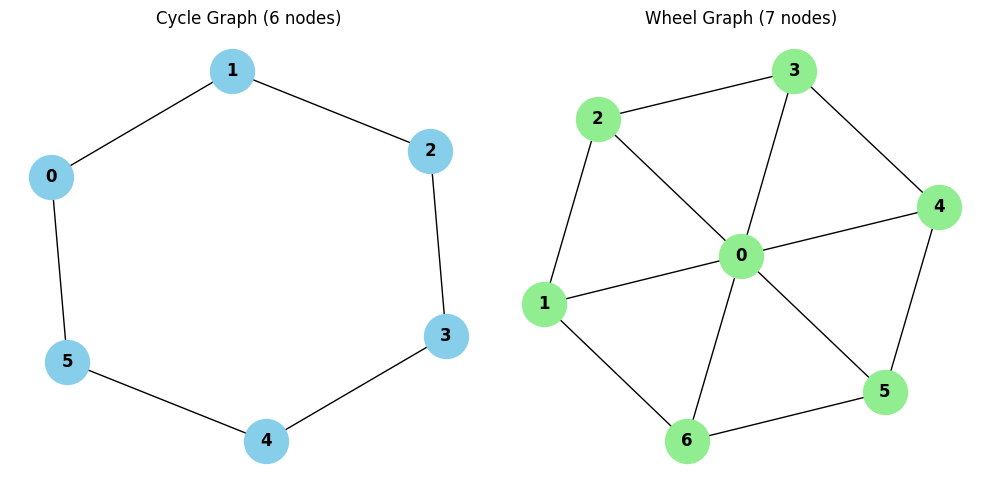

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个包含6个节点的环形图
G1 = nx.cycle_graph(6)

# 创建一个包含7个节点的轮形图
G2 = nx.wheel_graph(7)

# 绘制图形
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold')
plt.title('Cycle Graph (6 nodes)')

plt.subplot(1, 2, 2)
nx.draw(G2, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12, font_weight='bold')
plt.title('Wheel Graph (7 nodes)')

plt.tight_layout()
plt.show()


5.0


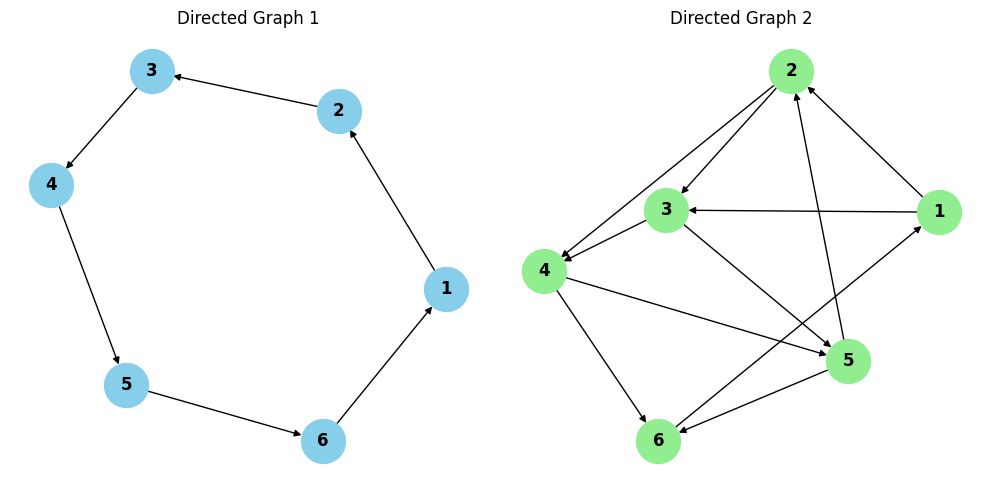

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个有向图
G1 = nx.DiGraph()
G1.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)])

# 创建另一个有向图
G2 = nx.DiGraph()
G2.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (1, 3), (3, 5), (5, 2), (2, 4), (4, 6), (6, 1)])
print(nx.graph_edit_distance(G1, G2))

# 绘制图形
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold', arrows=True)
plt.title('Directed Graph 1')

plt.subplot(1, 2, 2)
nx.draw(G2, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12, font_weight='bold', arrows=True)
plt.title('Directed Graph 2')

plt.tight_layout()
plt.show()


0.0
有向图中的边数为: 3 3


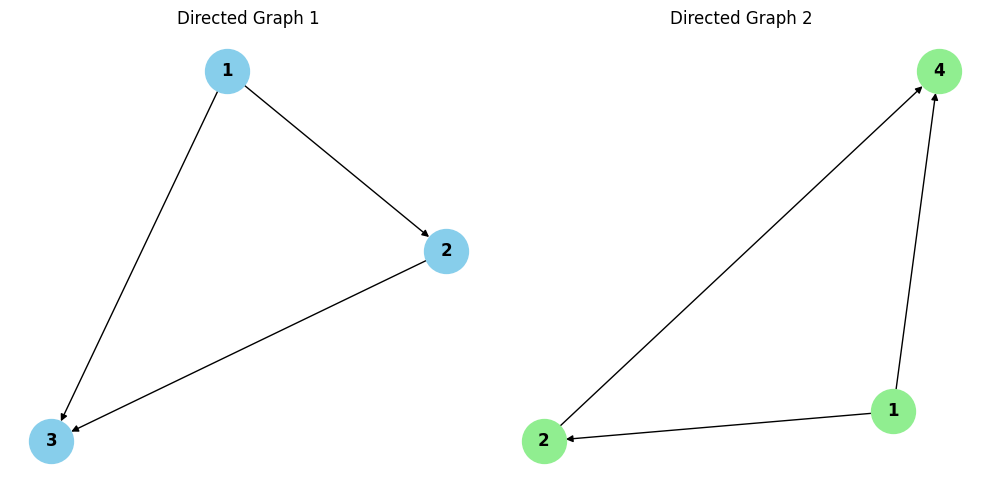

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个有向图
G1 = nx.DiGraph()
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])

# 创建另一个有向图
G2 = nx.DiGraph()
G2.add_edges_from([(1, 2), (2, 4), (1, 4)])
print(nx.graph_edit_distance(G1, G2))
num_edges = G1.number_of_edges()
num = G2.number_of_edges()

print("有向图中的边数为:", num_edges,num)


# 绘制图形
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold', arrows=True)
plt.title('Directed Graph 1')

plt.subplot(1, 2, 2)
nx.draw(G2, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12, font_weight='bold', arrows=True)
plt.title('Directed Graph 2')

plt.tight_layout()
plt.show()


In [ ]:
pip install vizro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.2/742.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.8/500.8 kB 20.0 MB/s eta 0:00:00


In [ ]:
import vizro

print(vizro.__version__)

INFO:vizro.charts._charts_utils:Overwriting plotly default template with vizro chart template. To revert back to the default template, run `import plotly.io as pio; pio.templates.default = 'plotly'`.


0.1.15


In [ ]:
import vizro.plotly.express as px
from vizro import Vizro
import vizro.models as vm

df = px.data.iris()

page = vm.Page(
    title="My first dashboard",
    components=[
        vm.Graph(id="scatter_chart", figure=px.scatter(df, x="sepal_length", y="petal_width", color="species")),
        vm.Graph(id="hist_chart", figure=px.histogram(df, x="sepal_width", color="species")),
    ],
    controls=[
        vm.Filter(column="species", selector=vm.Dropdown(value=["ALL"])),
    ],
)

dashboard = vm.Dashboard(pages=[page])

Vizro().build(dashboard).run()

ValidationError: 1 validation error for Graph
figure
  Component with id=scatter_chart already exists and is mapped to data bc0271d3-f0a9-4c50-b349-f77810e6de8a. Components must uniquely map to a data source across the whole dashboard. If you are working from a Jupyter Notebook, please either restart the kernel, or use 'from vizro import Vizro; Vizro._reset()`. (type=value_error)